In [1]:
import torch
import torchani
from torchani.datasets import ANIDataset
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torchani.units import hartree2kcalmol
from torchani.utils import PERIODIC_TABLE
from tqdm import tqdm

In [2]:
def tensors_from_xyz(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        num_atoms = int(lines[0])
        coordinates = []
        species = []
        element, a, b, c = lines[2].split()
        cell = torch.diag(torch.tensor([float(a), float(b), float(c)]))
        for line in lines[2:]:
            values = line.split()
            if values:
                s = values[0].strip()
                x = float(values[1])
                y = float(values[2])
                z = float(values[3])
                coordinates.append([x, y, z])
                species.append(PERIODIC_TABLE.index(s))
        coordinates = torch.tensor(coordinates)
        species = torch.tensor(species, dtype=torch.long)
        assert coordinates.shape[0] == num_atoms
        assert species.shape[0] == num_atoms
    return species, coordinates

In [5]:
device = torch.device('cpu')
ani2x = torchani.models.ANI2x().to(device).double()

ds_path = Path('/home/nick/First_DSs/ANI-1x-first-conformers.h5')

ds = ANIDataset(locations=ds_path, names=('1x_first'))

In [6]:
species = ds['CH4']['species'][0][None]
coordinates = ds['CH4']['coordinates'][0][None]
coordinates.requires_grad=True
ch4 = (species,coordinates)
#print('Input:',ch4)
energy = ani2x(ch4).energies
print('Energy:',energy)
derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
force = -derivative
print('Forces:',force)

Energy: tensor([-40.4850], dtype=torch.float64, grad_fn=<AddBackward0>)
Forces: tensor([[[-0.0156,  0.0030,  0.2010],
         [-0.0230, -0.0276, -0.0342],
         [ 0.0129, -0.0346, -0.0399],
         [ 0.0364,  0.0720, -0.1130],
         [-0.0107, -0.0128, -0.0139]]])


In [7]:
epoxide = tensors_from_xyz(Path('/home/nick/m-epoxide.xyz'))
epoxide[1].requires_grad=True
inp = (epoxide[0][None],epoxide[1][None])
#print(inp)

members_energies = ani2x.members_energies(inp).energies
sqrt_n = math.sqrt(len(epoxide[0]))
print('QBC:',hartree2kcalmol(members_energies.std(0)/sqrt_n).item(),'kcal/mol')

forces = []
net_forces = []
for i in members_energies:
    derivative = torch.autograd.grad(i,inp[1],retain_graph=True)[0]
    force = -derivative
    print(force)
    forces.append(force)
    for i,j,k in force[0]:
        print('stuff:',i,j,k)
        net_force = np.sqrt(np.square(i)+np.square(j)+np.square(k))
        print(net_force)

forces = hartree2kcalmol(torch.cat(forces, dim=0))
print('mean force:',forces.mean(0))
print('number of force vectors:',len(forces[0]))
print('Std in forces\n',forces.std(0),'(kcal/mol)/angstrom')

atomic_qbcs = hartree2kcalmol(ani2x.atomic_qbcs(inp).ae_stdev)

print('number of atomic energy stdev:',len(atomic_qbcs[0]))
print('Std atomic energies:\n',atomic_qbcs,'kcal/mol')

QBC: 1.0877656081497318 kcal/mol
tensor([[[-3.8387e-01,  5.6695e-02, -1.6399e-01],
         [ 3.7895e-01,  2.5011e-01,  2.1600e-01],
         [-9.8335e-02, -4.8238e-03,  6.4805e-02],
         [ 1.2641e-01, -3.3456e-01,  7.8023e-02],
         [-2.3414e-02,  4.6741e-02,  7.8610e-02],
         [-1.7501e-02, -7.0280e-03, -1.8987e-02],
         [ 3.8533e-02,  3.0614e-04, -2.6385e-02],
         [-3.5789e-02,  2.3303e-03, -1.5487e-02],
         [ 1.7867e-02, -9.1672e-04, -1.0586e-02],
         [-3.0008e-02,  4.8650e-03, -2.2818e-03],
         [ 3.1000e-03,  3.1048e-02, -1.8943e-02],
         [ 3.3110e-02,  9.9651e-03, -9.3382e-02],
         [-3.4537e-02, -4.0196e-02, -8.9960e-02],
         [-1.2917e-02,  3.3968e-03,  1.6722e-02],
         [ 1.2443e-02, -7.2994e-03, -3.0330e-02],
         [-5.5701e-03, -6.0645e-03,  1.9262e-02],
         [ 3.1531e-02, -4.5634e-03, -3.0910e-03]]])
stuff: tensor(-0.3839) tensor(0.0567) tensor(-0.1640)
tensor(0.4213)
stuff: tensor(0.3789) tensor(0.2501) tensor(0.

tensor([[[-0.4356,  0.0792, -0.2477],
         [ 0.4310,  0.2739,  0.2567],
         [-0.1084, -0.0117,  0.0595],
         [ 0.1629, -0.3736,  0.1332],
         [-0.0301,  0.0582,  0.0807],
         [-0.0141, -0.0148, -0.0382],
         [ 0.0314,  0.0016, -0.0125],
         [-0.0324,  0.0047, -0.0131],
         [ 0.0195, -0.0007, -0.0125],
         [-0.0253,  0.0019,  0.0027],
         [ 0.0019,  0.0265, -0.0195],
         [ 0.0287,  0.0199, -0.0999],
         [-0.0485, -0.0530, -0.1031],
         [-0.0137,  0.0019,  0.0183],
         [ 0.0051, -0.0046, -0.0238],
         [-0.0051, -0.0050,  0.0204],
         [ 0.0326, -0.0044, -0.0010]]])
stuff: tensor(-0.4356) tensor(0.0792) tensor(-0.2477)
tensor(0.5073)
stuff: tensor(0.4310) tensor(0.2739) tensor(0.2567)
tensor(0.5716)
stuff: tensor(-0.1084) tensor(-0.0117) tensor(0.0595)
tensor(0.1242)
stuff: tensor(0.1629) tensor(-0.3736) tensor(0.1332)
tensor(0.4288)
stuff: tensor(-0.0301) tensor(0.0582) tensor(0.0807)
tensor(0.1040)
stuff: tens

In [155]:
print(inp[0])

tensor([[8, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


17


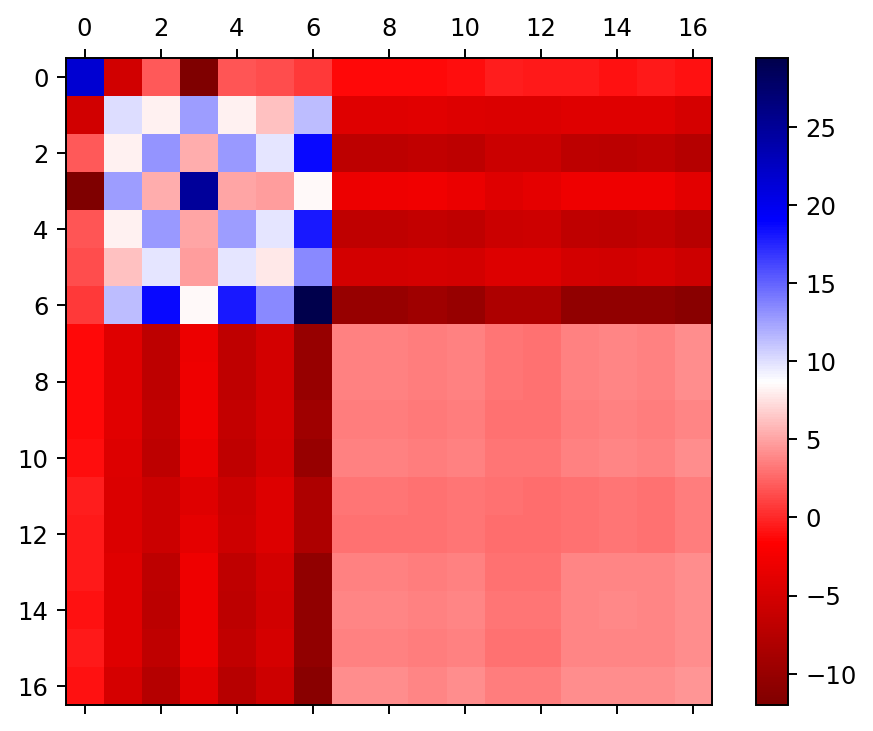

In [91]:
ae = hartree2kcalmol(ani2x.atomic_qbcs(inp).energies.squeeze().detach().numpy())
print(len(ae[0]))
ae_cov = np.cov(ae,rowvar=False)

plt.rcParams['figure.dpi'] = 175

fig, ax = plt.subplots()
img = ax.matshow(ae_cov, cmap='seismic_r')
fig.colorbar(img)

In [154]:
forces.split(3,dim=2)

(tensor([[[-2.4088e+02,  3.5577e+01, -1.0291e+02],
          [ 2.3779e+02,  1.5695e+02,  1.3554e+02],
          [-6.1706e+01, -3.0270e+00,  4.0666e+01],
          [ 7.9322e+01, -2.0994e+02,  4.8960e+01],
          [-1.4693e+01,  2.9330e+01,  4.9329e+01],
          [-1.0982e+01, -4.4102e+00, -1.1915e+01],
          [ 2.4180e+01,  1.9210e-01, -1.6557e+01],
          [-2.2458e+01,  1.4623e+00, -9.7181e+00],
          [ 1.1212e+01, -5.7525e-01, -6.6430e+00],
          [-1.8831e+01,  3.0528e+00, -1.4318e+00],
          [ 1.9453e+00,  1.9483e+01, -1.1887e+01],
          [ 2.0777e+01,  6.2532e+00, -5.8598e+01],
          [-2.1672e+01, -2.5223e+01, -5.6451e+01],
          [-8.1056e+00,  2.1315e+00,  1.0493e+01],
          [ 7.8079e+00, -4.5805e+00, -1.9032e+01],
          [-3.4953e+00, -3.8055e+00,  1.2087e+01],
          [ 1.9786e+01, -2.8636e+00, -1.9397e+00]],
 
         [[-2.5457e+02,  5.3074e+01, -1.6019e+02],
          [ 2.6463e+02,  2.3430e+02,  1.5379e+02],
          [-5.9036e+01,  6.2

17


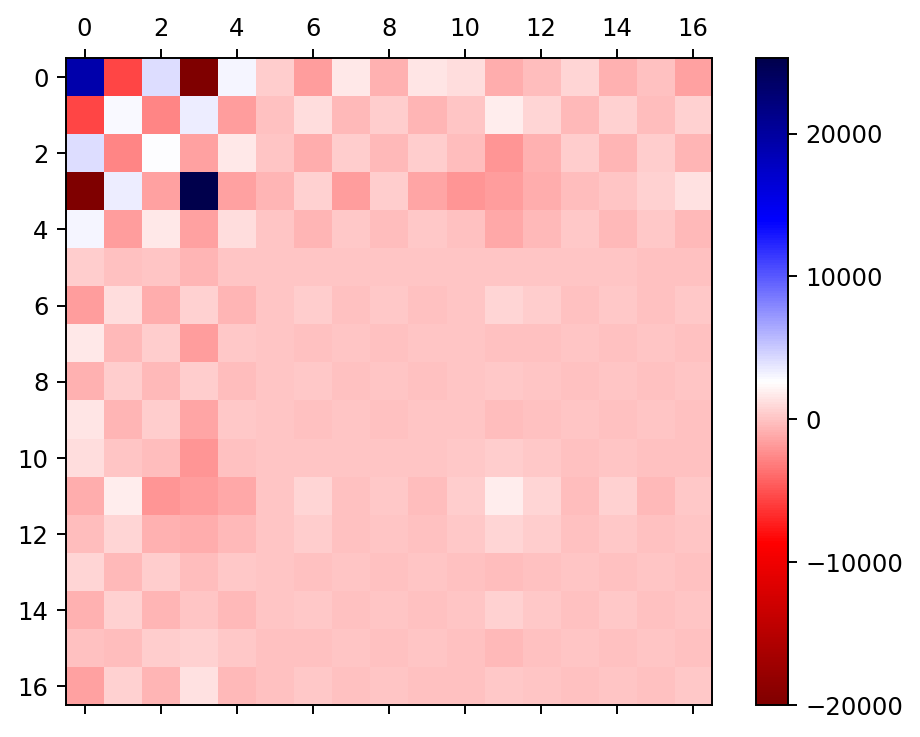

In [111]:
forces_cov = np.cov(forces[0])
print(len(forces_cov))
plt.rcParams['figure.dpi'] = 175

fig, ax = plt.subplots()
img = ax.matshow(forces_cov, cmap='seismic_r')
fig.colorbar(img)

In [28]:
species = ds['CH4']['species'][0][None]
coordinates = ds['CH4']['coordinates'][0][None]
print(coordinates)
coordinates.requires_grad=True
ch4 = (species,coordinates)
members_energies = ani2x.members_energies(ch4).energies
print(members_energies.shape)
forces = []
for i in members_energies:
    derivative = torch.autograd.grad(i,coordinates,retain_graph=True)[0]
    force = -derivative
    forces.append(force)
forces = torch.cat(forces, dim=0)
forces = hartree2kcalmol(forces)
print(forces)
print()
print(forces.mean(0))
print('stdev\n',forces.std(0))
print(hartree2kcalmol(ani2x(ch4).energies.item()))

tensor([[[ 4.9725e-04, -2.3656e-02, -4.6554e-02],
         [-9.4934e-01, -4.6713e-01, -2.1225e-01],
         [-2.1828e-01,  6.4611e-01,  8.7319e-01],
         [ 3.7291e-01,  6.5190e-01, -6.9571e-01],
         [ 7.9173e-01, -6.8895e-01,  3.1410e-01]]])
torch.Size([8, 1])
tensor([[[-10.1069,   1.8989, 126.1252],
         [-14.3177, -17.3228, -21.2256],
         [  8.1441, -21.9234, -25.4874],
         [ 22.9873,  45.3785, -70.7184],
         [ -6.7068,  -8.0312,  -8.6938]],

        [[ -9.8747,   1.2660, 125.3928],
         [-14.6457, -17.4627, -21.2496],
         [  7.8112, -21.2901, -24.2868],
         [ 23.2526,  45.6452, -71.2580],
         [ -6.5434,  -8.1584,  -8.5983]],

        [[ -9.7887,   2.5868, 126.5733],
         [-14.3187, -17.4524, -21.6035],
         [  8.1160, -21.9923, -25.0659],
         [ 22.8654,  44.7586, -70.9939],
         [ -6.8739,  -7.9008,  -8.9100]],

        [[-10.1678,   0.7376, 126.5377],
         [-14.0536, -17.1640, -21.5728],
         [  8.2096, -21.53

In [29]:
import ase
from ase.visualize import view
from ase.optimize import BFGS
from ase import io

ani2x = ani2x.double()

calculator = ani2x.ase()
numbers = species[0].detach().numpy()
positions = coordinates[0].detach().numpy()
print(positions)
molecule = ase.Atoms(numbers=numbers, positions=positions)
molecule.calc = calculator
dyn = BFGS(molecule)
dyn.run(fmax=0.0001)
new_coord = torch.tensor(molecule.positions)[None]
print(new_coord)
ani_inp = (species, new_coord)    
ch4_energies = ani2x(ani_inp).energies.item()
print(hartree2kcalmol(ch4_energies))

new_coord.requires_grad=True
print('coord:\n',new_coord)

members_energies = ani2x.members_energies(ani_inp).energies
print(members_energies.shape)
forces = []
for i in members_energies:
    derivative = torch.autograd.grad(i,new_coord,retain_graph=True)[0]
    force = -derivative
    forces.append(force)
forces = torch.cat(forces, dim=0)
forces = hartree2kcalmol(forces)
print('forces:\n',forces)
print()
print('stdev\n',forces.std(0))
print('mean forces:\n',forces.mean(0))
print(hartree2kcalmol(ani2x(ani_inp).energies.item()))

[[ 4.9725006e-04 -2.3656022e-02 -4.6553709e-02]
 [-9.4934297e-01 -4.6712598e-01 -2.1224843e-01]
 [-2.1827930e-01  6.4611226e-01  8.7318593e-01]
 [ 3.7291107e-01  6.5189767e-01 -6.9571298e-01]
 [ 7.9172766e-01 -6.8894786e-01  3.1409770e-01]]
      Step     Time          Energy         fmax
BFGS:    0 09:57:56    -1101.652212        5.4868
BFGS:    1 09:57:56    -1101.950567        1.6234
BFGS:    2 09:57:56    -1101.991349        0.8651
BFGS:    3 09:57:56    -1102.020865        0.5139
BFGS:    4 09:57:56    -1102.038562        0.4610
BFGS:    5 09:57:56    -1102.044180        0.1599
BFGS:    6 09:57:56    -1102.045011        0.0669
BFGS:    7 09:57:56    -1102.045154        0.0287
BFGS:    8 09:57:56    -1102.045203        0.0247
BFGS:    9 09:57:56    -1102.045240        0.0187
BFGS:   10 09:57:56    -1102.045261        0.0152
BFGS:   11 09:57:56    -1102.045267        0.0053
BFGS:   12 09:57:56    -1102.045267        0.0008
BFGS:   13 09:57:56    -1102.045267        0.0002
BFGS:   14

In [171]:
member_forces = []
mean_forces = []
force_qbcs = []
count=0

for index, conformer in tqdm(enumerate(ds.iter_conformers())):
    #print(conformer)
    species = conformer['species'][None].to(device)
    coordinates = conformer['coordinates'][None].to(device)
    coordinates.requires_grad=True
    assert len(species) == len(coordinates)
    ani_input = (species, coordinates)
    members_energies = ani2x.members_energies(ani_input).energies
    forces = []
    for i in members_energies:
        derivative = torch.autograd.grad(i,coordinates,retain_graph=True)[0]
        force = -derivative
        forces.append(force)
    forces = torch.cat(forces,dim=0)
    member_forces.append(forces)
    print(member_forces)
    mean_forces.append(forces.mean(0))
    force_qbcs.append(forces.std(0))
    #print(len(member_forces),len(mean_forces),len(force_qbcs))
    break
    count += 1
    #print('iter #', count)
    if count == 1:
        break

0it [00:00, ?it/s]

[tensor([[[ 0.0299,  0.1128,  0.0821],
         [ 0.0516, -0.0636,  0.0225],
         [-0.0292, -0.0116,  0.0701],
         [-0.0581, -0.0810, -0.0369],
         [ 0.0381,  0.1554, -0.0624],
         [ 0.1138,  0.0902,  0.0294],
         [ 0.0154, -0.1688, -0.0354],
         [ 0.0116,  0.2495,  0.0162],
         [ 0.0140, -0.1086,  0.0074],
         [-0.0927,  0.0360, -0.0966],
         [-0.0012, -0.0278, -0.0080],
         [-0.0396, -0.0272,  0.0150],
         [-0.0091,  0.0407, -0.0262],
         [ 0.0047, -0.0145, -0.0111],
         [-0.0133, -0.0153, -0.0279],
         [-0.0152, -0.0688,  0.0405],
         [-0.0217,  0.0005,  0.0088],
         [-0.0320,  0.0134,  0.0043],
         [-0.0331, -0.1008, -0.0149],
         [ 0.0659, -0.0104,  0.0228]],

        [[ 0.0267,  0.1146,  0.0859],
         [ 0.0603, -0.0725,  0.0208],
         [-0.0283, -0.0089,  0.0704],
         [-0.0566, -0.0780, -0.0364],
         [ 0.0389,  0.1528, -0.0627],
         [ 0.1088,  0.0897,  0.0285],
         

In [161]:
df = pd.DataFrame(columns=['Member forces', 'Mean forces', 'Force QBCs'])
df['Member forces'] = member_forces
df['Mean forces'] = mean_forces
df['Force QBCs'] = force_qbcs

In [172]:
df['Mean forces'].to_numpy()

array([tensor([[[ 0.0299,  0.1128,  0.0821],
                [ 0.0516, -0.0636,  0.0225],
                [-0.0292, -0.0116,  0.0701],
                [-0.0581, -0.0810, -0.0369],
                [ 0.0381,  0.1554, -0.0624],
                [ 0.1138,  0.0902,  0.0294],
                [ 0.0154, -0.1688, -0.0354],
                [ 0.0116,  0.2495,  0.0162],
                [ 0.0140, -0.1086,  0.0074],
                [-0.0927,  0.0360, -0.0966],
                [-0.0012, -0.0278, -0.0080],
                [-0.0396, -0.0272,  0.0150],
                [-0.0091,  0.0407, -0.0262],
                [ 0.0047, -0.0145, -0.0111],
                [-0.0133, -0.0153, -0.0279],
                [-0.0152, -0.0688,  0.0405],
                [-0.0217,  0.0005,  0.0088],
                [-0.0320,  0.0134,  0.0043],
                [-0.0331, -0.1008, -0.0149],
                [ 0.0659, -0.0104,  0.0228]],

               [[ 0.0267,  0.1146,  0.0859],
                [ 0.0603, -0.0725,  0.0208],
        

In [176]:
df['Member forces'].to_numpy()

array([tensor([[[ 0.0299,  0.1128,  0.0821],
                [ 0.0516, -0.0636,  0.0225],
                [-0.0292, -0.0116,  0.0701],
                [-0.0581, -0.0810, -0.0369],
                [ 0.0381,  0.1554, -0.0624],
                [ 0.1138,  0.0902,  0.0294],
                [ 0.0154, -0.1688, -0.0354],
                [ 0.0116,  0.2495,  0.0162],
                [ 0.0140, -0.1086,  0.0074],
                [-0.0927,  0.0360, -0.0966],
                [-0.0012, -0.0278, -0.0080],
                [-0.0396, -0.0272,  0.0150],
                [-0.0091,  0.0407, -0.0262],
                [ 0.0047, -0.0145, -0.0111],
                [-0.0133, -0.0153, -0.0279],
                [-0.0152, -0.0688,  0.0405],
                [-0.0217,  0.0005,  0.0088],
                [-0.0320,  0.0134,  0.0043],
                [-0.0331, -0.1008, -0.0149],
                [ 0.0659, -0.0104,  0.0228]],

               [[ 0.0267,  0.1146,  0.0859],
                [ 0.0603, -0.0725,  0.0208],
        

In [175]:
df['Force QBCs'].to_numpy()

array([tensor([[0.0026, 0.0023, 0.0040],
               [0.0030, 0.0033, 0.0021],
               [0.0020, 0.0031, 0.0011],
               [0.0018, 0.0046, 0.0007],
               [0.0023, 0.0014, 0.0008],
               [0.0021, 0.0016, 0.0003],
               [0.0016, 0.0020, 0.0004],
               [0.0035, 0.0027, 0.0009],
               [0.0018, 0.0023, 0.0014],
               [0.0026, 0.0028, 0.0033],
               [0.0008, 0.0012, 0.0016],
               [0.0020, 0.0010, 0.0022],
               [0.0020, 0.0020, 0.0016],
               [0.0009, 0.0013, 0.0006],
               [0.0003, 0.0009, 0.0006],
               [0.0006, 0.0006, 0.0004],
               [0.0006, 0.0004, 0.0001],
               [0.0008, 0.0003, 0.0001],
               [0.0017, 0.0016, 0.0005],
               [0.0014, 0.0016, 0.0015]])], dtype=object)

In [ ]:
look at epoxide example, compare atomistic components of energy and force to one another